In [ ]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Hourly Data incl 0 output




In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_stdf.csv', parse_dates=['date'])
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_stdf.csv', parse_dates=['date'])
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_stdf.csv', parse_dates=['date'])

In [ ]:
train_df.head()

,Year,Month,Day,Hour,GHI,TmpF,output,dew,humidity,precip,...,"Ice, Overcast",Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy","Snow, Overcast","Snow, Partially cloudy","Snow, Rain, Overcast","Snow, Rain, Partially cloudy"
0,2016,10,1,0,0.000000,56.997313,0.0,53.3,87.78,0.025,...,0,0,0,0,0,1,0,0,0,0
1,2016,10,1,1,0.000000,56.929524,0.0,53.3,91.47,0.005,...,0,0,0,0,1,0,0,0,0,0
2,2016,10,1,2,0.001702,57.055018,0.0,54.0,93.96,0.000,...,0,1,0,0,0,0,0,0,0,0
3,2016,10,1,3,0.065986,57.198007,1.0,54.0,92.12,0.021,...,0,0,0,0,1,0,0,0,0,0
4,2016,10,1,4,0.163879,57.340995,0.0,54.1,93.36,0.000,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI', 'TmpF', 'output', 'dew',
       'humidity', 'precip', 'snow', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'date', 'Clear',
       'Freezing Drizzle/Freezing Rain, Overcast', 'Ice, Overcast', 'Overcast',
       'Partially cloudy', 'Rain', 'Rain, Overcast', 'Rain, Partially cloudy',
       'Snow, Overcast', 'Snow, Partially cloudy', 'Snow, Rain, Overcast',
       'Snow, Rain, Partially cloudy'],
      dtype='object')

In [ ]:
x_train=train_df.drop(['Year','date','output'],axis=1)
y_train= train_df['output']

x_valid=valid_df.drop(['Year','date','output'],axis=1)
y_valid= valid_df['output']

x_test=test_df.drop(['Year','date','output'],axis=1)
y_test= test_df['output']

In [ ]:
x_train.shape

(37273, 25)

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

# validation set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [ ]:
y_test_transformed

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
x_train_transformed.shape

(37270, 3, 25)

In [ ]:
y_train_transformed

array([1., 0., 0., ..., 0., 0., 0.])

In [ ]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(num_steps, 25), return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                3680      
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,121
Trainable params: 4,121
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_path = 'data298__daily_lstm.h5'

In [ ]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=100,validation_data=(x_valid_transformed,y_valid_transformed))

Epoch 1/100
1165/1165 [==============================] - 10s 6ms/step - loss: 12347273.0000 - mae: 1934.8525 - r2_keras: -0.3899 - val_loss: 13124186.0000 - val_mae: 2016.5173 - val_r2_keras: -83142608.0000
Epoch 2/100
1165/1165 [==============================] - 6s 5ms/step - loss: 10542919.0000 - mae: 1912.2593 - r2_keras: -0.1806 - val_loss: 12944147.0000 - val_mae: 2001.6831 - val_r2_keras: -113258272.0000
Epoch 3/100
1165/1165 [==============================] - 7s 6ms/step - loss: 8562540.0000 - mae: 1936.7452 - r2_keras: 0.0403 - val_loss: 12865242.0000 - val_mae: 2001.4260 - val_r2_keras: -26503456.0000
Epoch 4/100
1165/1165 [==============================] - 6s 5ms/step - loss: 6878501.5000 - mae: 1891.6016 - r2_keras: 0.2236 - val_loss: 12703186.0000 - val_mae: 1993.1058 - val_r2_keras: -41840944.0000
Epoch 5/100
1165/1165 [==============================] - 7s 6ms/step - loss: 5593429.0000 - mae: 1825.3260 - r2_keras: 0.3585 - val_loss: 12795761.0000 - val_mae: 2002.5575 - val

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


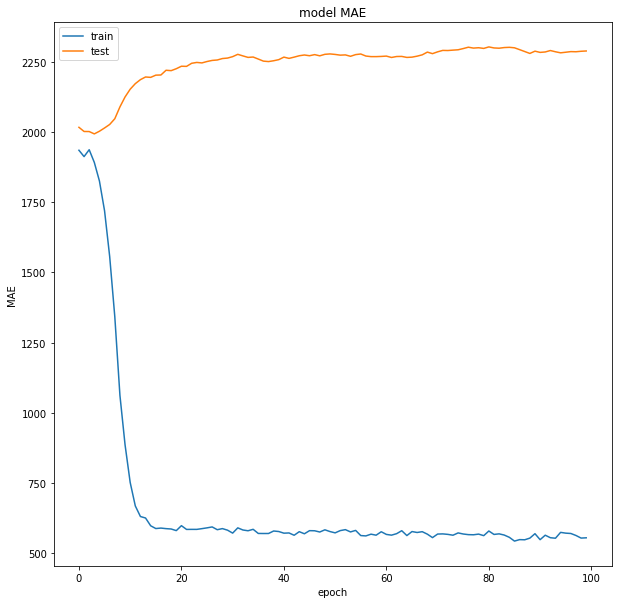

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

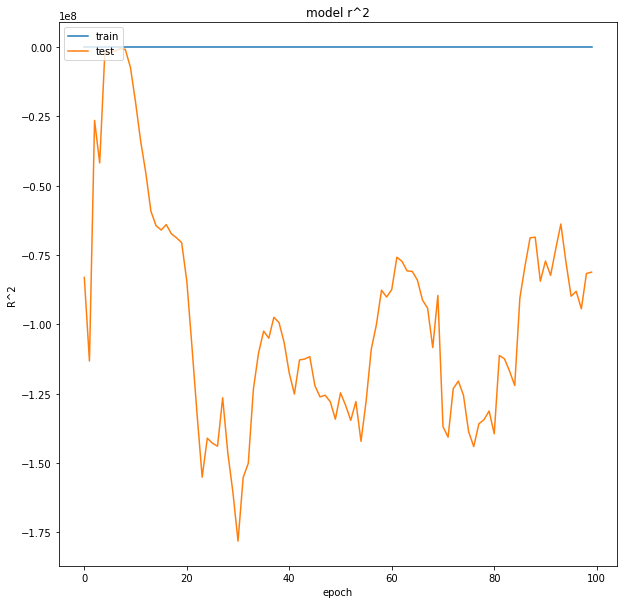

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predict = model.predict(x_test_transformed)

320/320 [==============================] - 1s 2ms/step


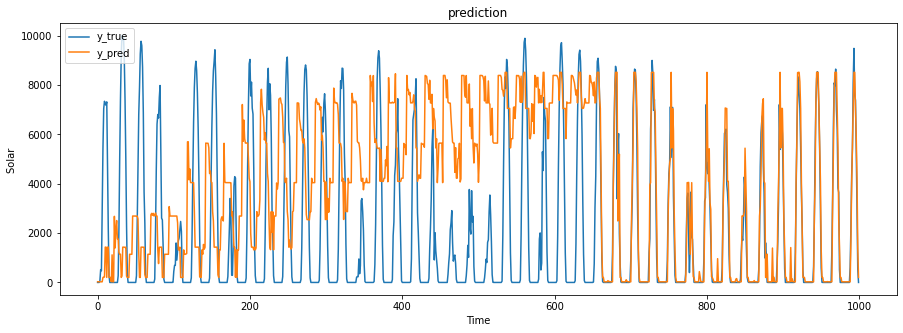

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(15, 5))
plt.plot(y_test_transformed[:1000])
plt.plot(test_predict[:1000])
plt.title('prediction')
plt.ylabel('Solar ')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
mean_absolute_percentage_error(y_test_transformed, test_predict)

8.165880124202728e+17

In [ ]:
mean_absolute_error(y_test_transformed, test_predict)

761.7694196925916

In [ ]:
r2_score(y_test_transformed, test_predict)

0.7079063320944423

In [ ]:
mean_squared_error(y_test_transformed, test_predict,squared=False)

1607.3572566661196

### Hourly Data No 0 output

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_df_no0_scaled.csv', parse_dates=['date'])
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_df_no0_scaled.csv', parse_dates=['date'])
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_df_no0_scaled.csv', parse_dates=['date'])

In [ ]:
train_df.head()

,Year,Month,Day,Hour,GHI,TmpF,output,dew,humidity,precip,snow,sealevelpressure,cloudcover,visibility,solarradiation,date
0,2016,10,1,3,-1.143079,-0.272506,1.0,0.325886,1.492652,0.514650,-0.045143,-0.208282,1.403860,-3.059949,-1.046464,2016-10-01
1,2016,10,1,7,-1.064765,-0.240862,208.0,0.331360,1.382033,-0.176102,-0.045143,-0.223053,1.469317,-1.842624,-1.045319,2016-10-01
2,2016,10,1,8,-1.076574,-0.217895,193.0,0.380626,1.423381,-0.176102,-0.045143,-0.163969,1.469317,-2.451286,-0.901080,2016-10-01
3,2016,10,1,9,-0.855667,-0.185494,971.0,0.391574,1.392235,-0.176102,-0.045143,-0.090114,1.469317,-3.181681,-0.640839,2016-10-01
4,2016,10,1,10,-0.614201,-0.140744,1847.0,0.424419,1.339074,-0.176102,-0.045143,-0.075343,1.469317,-2.573019,-0.622523,2016-10-01


In [ ]:
train_df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'GHI', 'TmpF', 'output', 'dew',
       'humidity', 'precip', 'snow', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'date'],
      dtype='object')

In [ ]:
x_train=train_df.drop(['Year','date','output'],axis=1)
y_train= train_df['output']

x_valid=valid_df.drop(['Year','date','output'],axis=1)
y_valid= valid_df['output']

x_test=test_df.drop(['Year','date','output'],axis=1)
y_test= test_df['output']

In [ ]:
x_train.shape

(19441, 13)

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

# validation set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [ ]:
y_test_transformed

array([1792., 3496., 6264., ..., 1232.,  320.,   64.])

In [ ]:
x_train_transformed.shape

(19438, 3, 13)

In [ ]:
y_train_transformed

array([ 971., 1847., 2372., ...,  400.,  216.,   16.])

In [ ]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(num_steps, 13), return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                2720      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_path = 'data298__daily_lstm.h5'

In [ ]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=100,validation_data=(x_valid_transformed,y_valid_transformed))

Epoch 1/100
608/608 [==============================] - 8s 8ms/step - loss: 23919434.0000 - mae: 3648.5625 - r2_keras: -1.3086 - val_loss: 23086108.0000 - val_mae: 3638.4302 - val_r2_keras: -1.5830
Epoch 2/100
608/608 [==============================] - 3s 5ms/step - loss: 21338968.0000 - mae: 3390.9287 - r2_keras: -1.0554 - val_loss: 19555122.0000 - val_mae: 3307.1350 - val_r2_keras: -1.1871
Epoch 3/100
608/608 [==============================] - 3s 6ms/step - loss: 17646564.0000 - mae: 3090.0435 - r2_keras: -0.6965 - val_loss: 15685676.0000 - val_mae: 3019.8962 - val_r2_keras: -0.9329
Epoch 4/100
608/608 [==============================] - 4s 7ms/step - loss: 14292381.0000 - mae: 2903.6565 - r2_keras: -0.3710 - val_loss: 12671632.0000 - val_mae: 2841.0017 - val_r2_keras: -1.0012
Epoch 5/100
608/608 [==============================] - 3s 6ms/step - loss: 11425073.0000 - mae: 2665.4631 - r2_keras: -0.0972 - val_loss: 9596790.0000 - val_mae: 2464.4829 - val_r2_keras: -0.8842
Epoch 6/100
608/

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


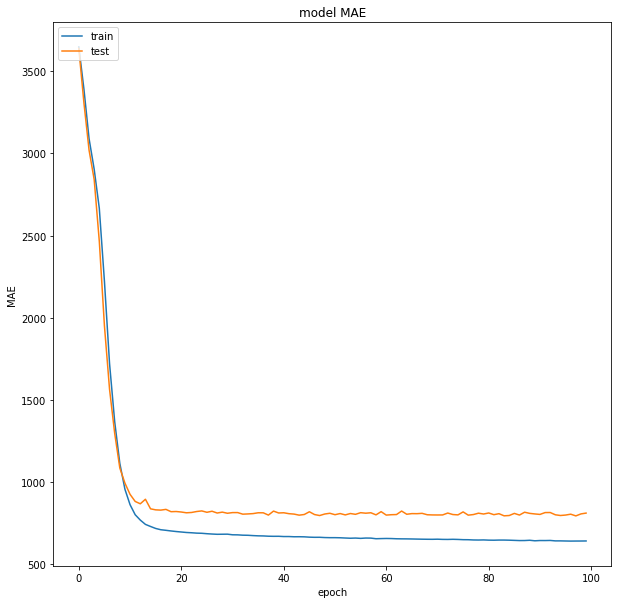

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

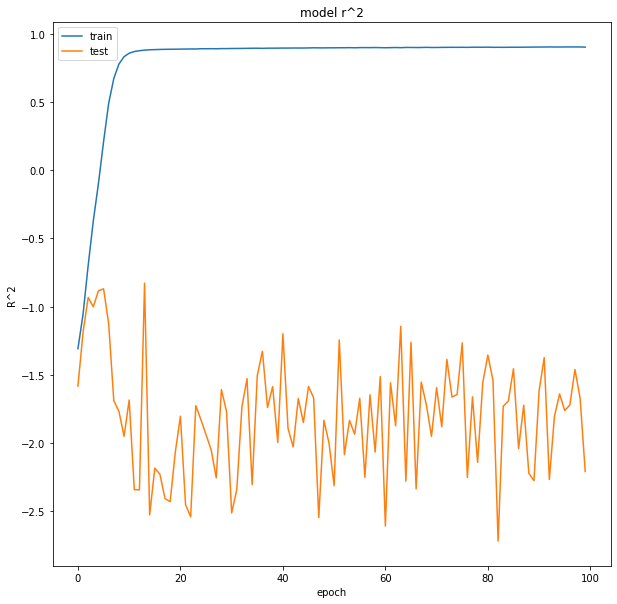

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predict = model.predict(x_test_transformed)

99/99 [==============================] - 1s 2ms/step


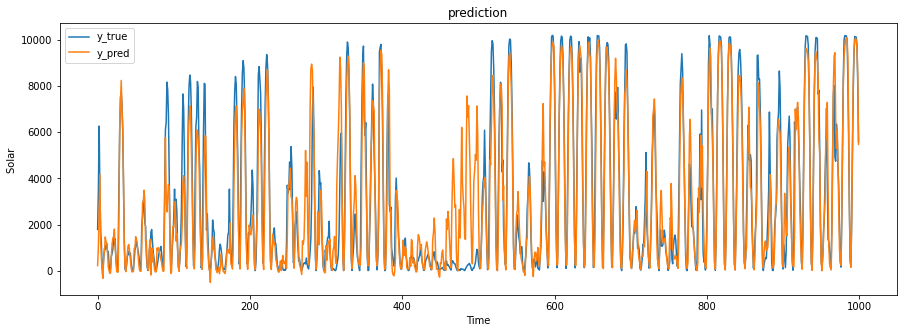

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(15, 5))
plt.plot(y_test_transformed[:1000])
plt.plot(test_predict[:1000])
plt.title('prediction')
plt.ylabel('Solar ')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
mean_absolute_percentage_error(y_test_transformed, test_predict)

1.3948449156901832

In [ ]:
mean_absolute_error(y_test_transformed, test_predict)

832.5162904342977

In [ ]:
r2_score(y_test_transformed, test_predict)

0.8192018109907928

### Daily Data

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/train_daily_scaled.csv', parse_dates=['date'])
test_df  = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/test_daily_scaled.csv', parse_dates=['date'])
valid_df = pd.read_csv('/content/drive/Shareddrives/DATA 298A/DATA/val_daily_scaled.csv', parse_dates=['date'])

In [ ]:
train_df.head()

,date,GHI,TmpF,dew,humidity,snow,sealevelpressure,cloudcover,visibility,solarradiation,precip,output,year,month,day
0,2016-10-01,-0.911144,0.189517,0.543633,1.533085,-0.133726,-0.190797,1.580204,-2.268354,-0.134032,-0.232540,23159.0,2016,10,1
1,2016-10-02,-0.547337,0.438511,0.685913,0.824246,-0.133726,-0.026193,1.760792,-0.181476,0.625929,-0.391188,34483.0,2016,10,2
2,2016-10-03,0.014224,0.493965,0.508993,0.368191,-0.133726,-0.002955,-0.338909,-1.218789,0.533475,-0.420033,52849.0,2016,10,3
3,2016-10-04,0.177402,0.706897,0.582691,-0.148064,-0.133726,-0.122373,-0.176146,0.533208,0.762740,-0.420033,59870.0,2016,10,4
4,2016-10-05,0.246676,0.796062,0.703815,-0.402916,-0.133726,0.075797,0.090207,0.659810,0.705958,-0.420033,62184.0,2016,10,5


In [ ]:
train_df.columns

Index(['date', 'GHI', 'TmpF', 'dew', 'humidity', 'snow', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'precip', 'output',
       'year', 'month', 'day'],
      dtype='object')

In [ ]:
x_train=train_df.drop(['year','date','output'],axis=1)
y_train= train_df['output']

x_valid=valid_df.drop(['year','date','output'],axis=1)
y_valid= valid_df['output']

x_test=test_df.drop(['year','date','output'],axis=1)
y_test= test_df['output']

In [ ]:
x_train.shape

(1553, 12)

In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
num_steps = 3
# training set
(x_train_transformed,
 y_train_transformed) = lstm_data_transform(x_train, y_train, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
 y_test_transformed) = lstm_data_transform(x_test, y_test, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

# validation set
(x_valid_transformed,
 y_valid_transformed) = lstm_data_transform(x_valid, y_valid, num_steps=num_steps)
assert x_valid_transformed.shape[0] == y_valid_transformed.shape[0]

In [ ]:
y_test_transformed

array([1792., 3496., 6264., ..., 1232.,  320.,   64.])

In [ ]:
x_train_transformed.shape

(1550, 3, 12)

In [ ]:
y_train_transformed

array([ 971., 1847., 2372., ...,  400.,  216.,   16.])

In [ ]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
model = Sequential()
model.add(LSTM(20, activation='tanh', input_shape=(num_steps, 12), return_sequences=False))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2640      
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model_path = 'data298__daily_lstm.h5'

In [ ]:
history= model.fit(x_train_transformed, y_train_transformed, epochs=100,validation_data=(x_valid_transformed,y_valid_transformed))

Epoch 1/100
49/49 [==============================] - 1s 10ms/step - loss: 294793888.0000 - mae: 14046.6865 - r2_keras: 0.5140 - val_loss: 396358176.0000 - val_mae: 16409.2246 - val_r2_keras: 0.0566
Epoch 2/100
49/49 [==============================] - 1s 15ms/step - loss: 294699968.0000 - mae: 14052.4180 - r2_keras: 0.5086 - val_loss: 396630304.0000 - val_mae: 16420.8965 - val_r2_keras: 0.0550
Epoch 3/100
49/49 [==============================] - 1s 20ms/step - loss: 294397696.0000 - mae: 14018.0518 - r2_keras: 0.5094 - val_loss: 398767968.0000 - val_mae: 16430.1699 - val_r2_keras: 0.0504
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 293749824.0000 - mae: 14023.5273 - r2_keras: 0.5131 - val_loss: 396239904.0000 - val_mae: 16397.7988 - val_r2_keras: 0.0554
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 293277920.0000 - mae: 13988.9492 - r2_keras: 0.5148 - val_loss: 396808064.0000 - val_mae: 16390.7305 - val_r2_keras: 0.0546
Epoch 6/100


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


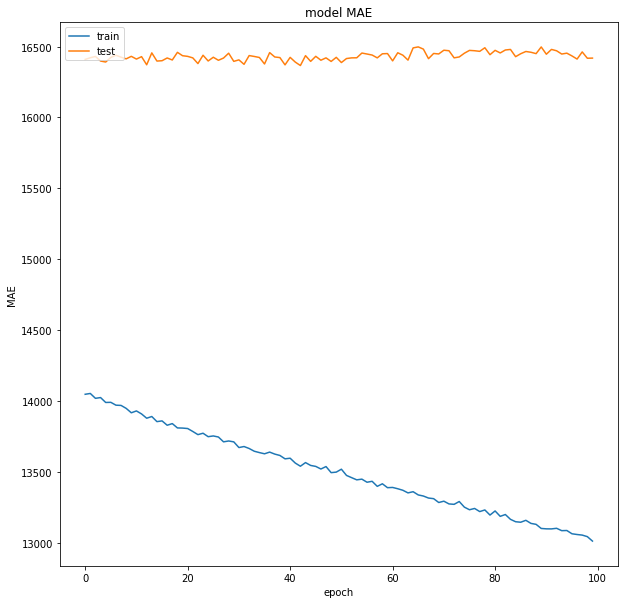

In [ ]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

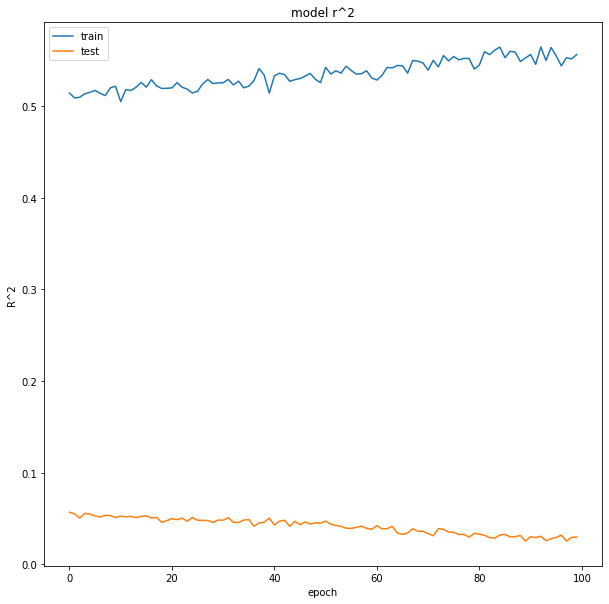

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predict = model.predict(x_test_transformed)

14/14 [==============================] - 0s 2ms/step


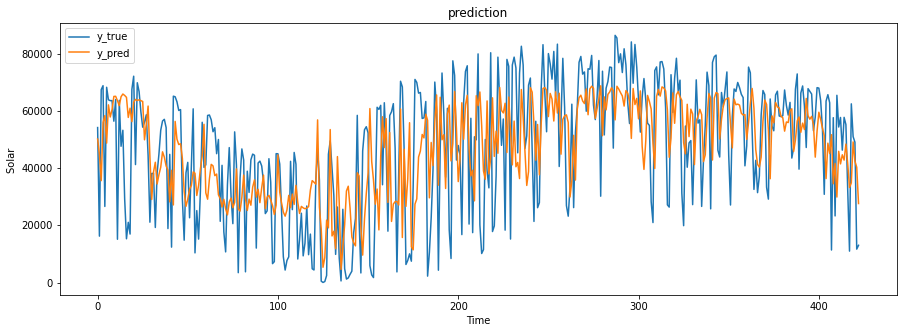

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(15, 5))
plt.plot(y_test_transformed[:1000])
plt.plot(test_predict[:1000])
plt.title('prediction')
plt.ylabel('Solar ')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
mean_absolute_percentage_error(y_test_transformed, test_predict)

1.6099676524698772

In [ ]:
mean_absolute_error(y_test_transformed, test_predict)

15776.46946683843

In [ ]:
r2_score(y_test_transformed, test_predict)

0.25674653025737937

In [ ]:
mean_squared_error(y_test_transformed, test_predict,squared=False)

19521.78973735412